In this notebook we load a AIA cutout image and look into the jet catalogue to plot all the boxes of all the jets relevant to that cutout image.

## Load a AIA cutout image
In the previously downloaded cutout (see corresponding notebook if you need to download cutouts)

In [1]:
data_path = 'data/sjh_cutouts/sjh_2015-09-22T21_1/'

In [2]:
import glob
import sunpy.map

C:\Users\SMusset\anaconda3\envs\sunpyenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
files = glob.glob(data_path+"/aia.lev1_euv_12s.*.304.image.fits")
aia_map = sunpy.map.Map(files[52])
aia_frame_date = aia_map.date.datetime64

## Load jet catalogue

In [4]:
import numpy as np
from utils.Jet_class_light import json_import_list

In [5]:
json_file = 'exports/Jet_clusters_3.0_2.0.paperID.json'
Jet_catalogue=json_import_list(json_file)

The 883 JetCluster objects are imported from exports/Jet_clusters_3.0_2.0.paperID.json.


In [6]:
jet_start_time = np.array([Jet_catalogue[i].obs_time for i in range(len(Jet_catalogue))], dtype='datetime64')
jet_dur = np.array([Jet_catalogue[i].Duration for i in range(len(Jet_catalogue))], dtype=float)
jet_end_time = jet_start_time + (jet_dur*60).astype('timedelta64[s]')

## Find jets associated with the AIA cutout image
And plot the jet boxes on the AIA map

### Find other jets in the catalogue happening at the time of the AIA frame
Check if there are any other jet in the catalogue that match the aia frame time and print relevant times. Note that you will find the current jet too! I am keeping everything as it is simple.

In [7]:
# Finding all jets that exist for this data frame
matching_time_jets = np.where(np.array([jet_start_time < aia_frame_date])*np.array([jet_end_time > aia_frame_date]))[1]
print('cutout time: ', aia_frame_date)
print('associated jets: start and end times:')
for jetindice in matching_time_jets:
    print(jet_start_time[jetindice], jet_end_time[jetindice])

cutout time:  2015-09-22T22:16:54.123000000
associated jets: start and end times:
2015-09-22T21:56:06.000000 2015-09-22T22:27:42.000000
2015-09-22T22:11:42.000000 2015-09-22T22:17:18.000000


### If jets where found, now check if their box overlap with the AIA frame
Extract FOV corners from the AIA cutout and make a polygon

In [8]:
from shapely.geometry import Polygon
from utils.Jet_box_class import make_cluster_box, make_subject_box, plot_all_subject_boxes_and_average_box

In [9]:
xmin = aia_map.bottom_left_coord.Tx.value
ymin = aia_map.bottom_left_coord.Ty.value
xmax = aia_map.top_right_coord.Tx.value
ymax = aia_map.top_right_coord.Ty.value
poly_cutout_fov = Polygon([(xmin,ymin), (xmin,ymax), (xmax,ymax), (xmax,ymin)])

For each jet, extract the box associated with that frame, create a polygon, and check if there is intersection with the cutout FOV

In [10]:
jet_in_fov = []
jet_boxes = []
for jetindice in matching_time_jets:
    # find the subject associated with the aia frame
    subjects_start_time_temp = []
    for jet in Jet_catalogue[jetindice].jets:
        subjects_start_time_temp.append(jet.time)
    subject_idn_temp = np.max(np.where(subjects_start_time_temp < aia_map.date.datetime64))
    # extract corresponding box
    subject_box_temp = make_subject_box(Jet_catalogue[jetindice].jets[subject_idn_temp])
    # make polygon
    jet_poly_temp = Polygon(subject_box_temp.corners(no_unit=True))
    # check if intersection
    jet_in_fov.append(poly_cutout_fov.intersects(jet_poly_temp))
    # if intersection, keep the box for further analysis
    if poly_cutout_fov.intersects(jet_poly_temp):
        jet_boxes.append(subject_box_temp)

### Plot cutout map and boxes

In [11]:
import matplotlib.pyplot as plt
import astropy.units as u

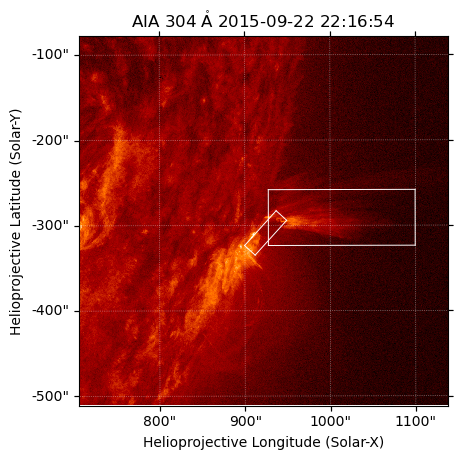

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection=aia_map)
image = aia_map.plot(axes=ax)

## Plot all the boxes that were found - this should include the original jet

for additional_box in jet_boxes:
    for line in additional_box.lines_to_plot():
        ax.plot(line[0]*u.arcsec.to(u.deg), line[1]*u.arcsec.to(u.deg),
                color='white', linewidth=0.7,
                transform=ax.get_transform("world")) 

plt.show()